# Make sure that you are using the same version of python and sklearn for compatibility

In [1]:
from platform import python_version
print(python_version())
import sklearn
print((sklearn.__version__) )

3.9.13
1.2.1


In [2]:
import sys
required_version = (3, 9, 0)  # The minimum required Python version
if sys.version_info < required_version:
    raise ValueError(f"Python version {required_version[0]}.{required_version[1]} or higher is required, but current version is {sys.version_info[0]}.{sys.version_info[1]}")
else:
    print('The minimum required Python version is satisfied!')

required_version_sklearn = (1, 2, 1)  # The minimum required sklearn version
your_sklearn_version = (int(sklearn.__version__[0]),int(sklearn.__version__[2]),int(sklearn.__version__[4]))
if your_sklearn_version < required_version_sklearn:
    raise ValueError(f"Sklearn version {required_version_sklearn[0]}.{required_version_sklearn[1]} or higher is required, but current version is {your_sklearn_version[0]}.{your_sklearn_version[1]}")
else:
    print('The minimum required sklearn version is satisfied!')

The minimum required Python version is satisfied!
The minimum required sklearn version is satisfied!


In [3]:
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pickle
import requests
import os
import joblib
import gzip

## Load the saved models

first dowonload the saved models in pickle format from gitub (.sav files)
* https://github.com/farhadseda/ML-Based-GMMs-for-NGA-West2

In [4]:
# load the model from disk
ANN = joblib.load("./ANN.joblib")  
KRR = joblib.load("./KRR.joblib")
RFR = joblib.load("./RFR.joblib")
SVR = joblib.load("./SVR.joblib")

In [5]:
ANN

MultiOutputRegressor(estimator=Pipeline(steps=[('columntransformer-1',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('functiontransformer',
                                                                                 FunctionTransformer(feature_names_out='one-to-one',
                                                                                                     func=<ufunc 'log'>),
                                                                                 ['ClstD_km',
                                                                                  'Vs30_Selected_for_Analysis_m_s'])],
                                                                  verbose_feature_names_out=False)),
                                               ('columntransformer-2',
                                                ColumnTransformer(transformers=[('minmaxscaler',
                                                                                 MinMaxScaler(),
                                                                                 ['Earthquake_Magnitude',
                                                                                  'ClstD_km',
                                                                                  'Ztor_km',
                                                                                  'Vs30_Selected_for_Analysis_m_s'])],
                                                                  verbose_feature_names_out=False)),
                                               ('mlpregressor',
                                                MLPRegressor(activation='tanh',
                                                             alpha=0.1,
                                                             batch_size=128,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=(8,
                                                                                 4),
                                                             max_iter=500,
                                                             random_state=42,
                                                             tol=1e-05))]),
                     n_jobs=4)

## Function to plot the distance scaling

In [6]:
# plot distance scaling
def plot_dist_scaling(df_plot, predicted):
    # plt.figure(figsize = (8,7))
    color = ['purple','blue','green','yellow','red','black']
    styles = ['-','--','-.','-','--']
    d = list(set(df_plot['ClstD_km'].tolist()))
    d.sort()
    for m, j,style in zip(df_plot.Earthquake_Magnitude.unique(),color, styles):
        plt.loglog(d, np.exp(predicted[df_plot.Earthquake_Magnitude == m]), style, linewidth=3, color = j, label = 'M'+str(m))
       
    plt.legend()
    plt.xlabel('Rupture Distance (km)')
    plt.ylabel('Acceleration (g)')
    plt.ylim([0.000001, 10])
    plt.xlim([1, 300])

## Function to create the dataframe for prediction

In [7]:
# function to create the data needed for plotting
def data_for_plot(Vs: list, Ztor: list):
    # M = list(np.linspace(5,8.5,8))
    M = list(np.arange(3.5,8,1))
    d = list(range(1,300,1))
    List = [M, d, Ztor, Vs]

    combination = [p for p in itertools.product(*List)]

    df = pd.DataFrame(combination, columns =
                      ['Earthquake_Magnitude', 'ClstD_km', 'Ztor_km','Vs30_Selected_for_Analysis_m_s'],
                                               dtype = float) 
    return df

## Periods and weights of each individual model

In [8]:
# required columns from the processed data
# to retriev PGA use column 0, to retrive PSA0.01 s use column 1 and so on.
# Thus PSA0.2 is column 8
periods = ['PGA_g','T0pt010S','T0pt020S','T0pt030S','T0pt050S','T0pt075S','T0pt100S','T0pt150S',
          'T0pt200S','T0pt250S','T0pt300S', 'T0pt400S','T0pt500S','T0pt750S','T1pt000S',
          'T1pt500S','T2pt000S','T3pt000S','T4pt000S','T5pt000S','T7pt500S','T10pt000S',
          'PGV_cm_sec','PGD_cm']

# to plot response spectra
T = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7.5, 10]

# wieght to combine different schemes: w0: RFR, w1: ANN, w2: KRR, w3: SVR
w = [0.25, 0.25, 0.25, 0.25]    

# Prediction with VS30 = 400 m/s and Ztor = 5 km for PGA and PSA at 0.2 s

In [9]:
t0 = time.time()
df_plot = data_for_plot(Vs=[400], Ztor=[5])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 19.77 s


Text(0.5, 1.0, 'PSA at 0.2 s')

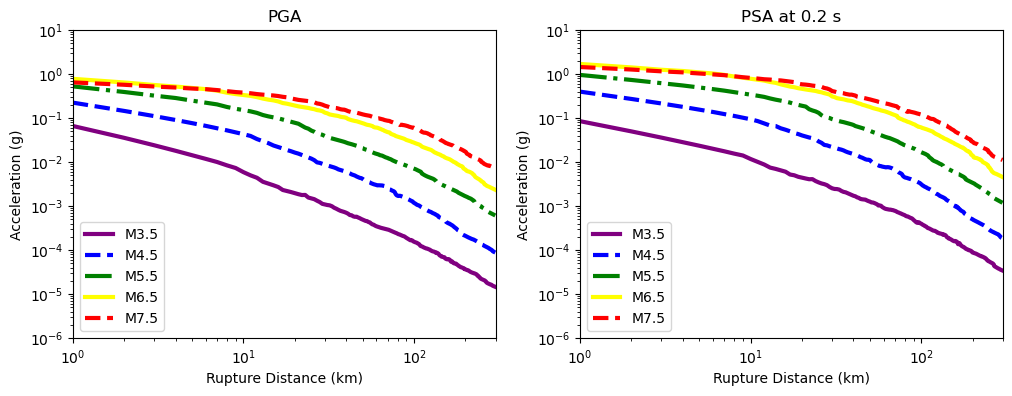

In [10]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA')
plt.subplot(1,2,2)
# PSA0.2 is column 8
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,8])
plt.title('PSA at 0.2 s')

# Prediction with VS30 = 760 m/s and Ztor = 0 km for PGA and PSA at 1.0 s

In [11]:
t0 = time.time()
df_plot = data_for_plot(Vs=[760], Ztor=[0])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 15.25 s


Text(0.5, 1.0, 'PSA at 1.0 s')

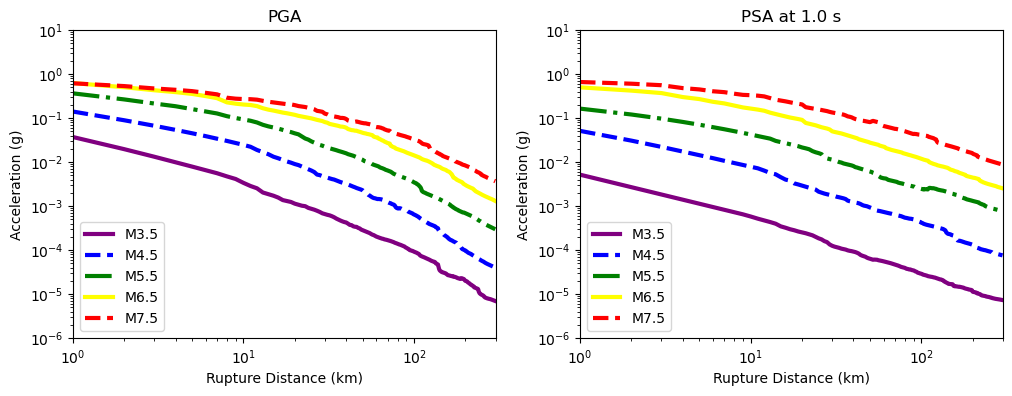

In [12]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA')
plt.subplot(1,2,2)
# PSA1 is column 14
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,14])
plt.title('PSA at 1.0 s')

### To see the predicted data in ln format

In [13]:
df_plot_predict_ensemble.head()

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
0,-3.290725,-3.269832,-3.252867,-3.091289,-2.841735,-2.810180,-2.828375,-2.851033,-2.990443,-3.183940,...,-5.262596,-6.210437,-6.823935,-7.669942,-8.323875,-8.780793,-9.600364,-10.173715,-0.052626,-2.699700
1,-3.926657,-3.905925,-3.890503,-3.738947,-3.481908,-3.408420,-3.409721,-3.406168,-3.531432,-3.732813,...,-5.915407,-6.833412,-7.415407,-8.232929,-8.885852,-9.344375,-10.182918,-10.774127,-0.630638,-3.227554
2,-4.322052,-4.301292,-4.287322,-4.142652,-3.883941,-3.775880,-3.763051,-3.741541,-3.859876,-4.067282,...,-6.296932,-7.204982,-7.777582,-8.584709,-9.237700,-9.698654,-10.549234,-11.150207,-0.993367,-3.557478
3,-4.611231,-4.590459,-4.577742,-4.438752,-4.180360,-4.044910,-4.020095,-3.984567,-4.098322,-4.309931,...,-6.566691,-7.472193,-8.042413,-8.845677,-9.498159,-9.961276,-10.820544,-11.428179,-1.258536,-3.799785
4,-4.839154,-4.818405,-4.806761,-4.672786,-4.415557,-4.258334,-4.223223,-4.176114,-4.286411,-4.501001,...,-6.776085,-7.681947,-8.252598,-9.054956,-9.706425,-10.171343,-11.037294,-11.649959,-1.467593,-3.992084


### To see the predicted data in g or cm/s

In [14]:
np.exp(df_plot_predict_ensemble.tail())

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
1490,0.003761,0.003760,0.003778,0.003680,0.003945,0.004975,0.005466,0.006181,0.006917,0.007485,...,0.008917,0.008047,0.006917,0.004961,0.004395,0.004521,0.005263,0.004475,1.676473,3.393674
1491,0.003739,0.003738,0.003756,0.003659,0.003921,0.004946,0.005433,0.006143,0.006875,0.007443,...,0.008883,0.008023,0.006898,0.004949,0.004386,0.004512,0.005258,0.004473,1.671297,3.389205
1492,0.003717,0.003716,0.003735,0.003637,0.003897,0.004916,0.005400,0.006106,0.006834,0.007400,...,0.008849,0.007998,0.006879,0.004937,0.004376,0.004504,0.005254,0.004472,1.666152,3.384757
1493,0.003696,0.003695,0.003713,0.003616,0.003874,0.004887,0.005367,0.006068,0.006793,0.007358,...,0.008816,0.007974,0.006861,0.004925,0.004366,0.004495,0.005250,0.004470,1.661039,3.380331
1494,0.003674,0.003673,0.003692,0.003594,0.003850,0.004858,0.005335,0.006031,0.006753,0.007317,...,0.008782,0.007950,0.006842,0.004913,0.004357,0.004487,0.005246,0.004469,1.655957,3.375925


### Plotting each inividual ML models abd the ensemble

In [15]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[5])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(1, 300)

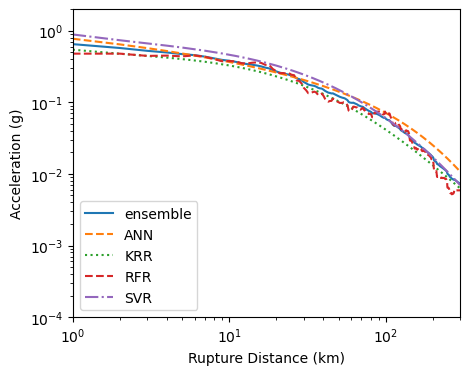

In [16]:
# define the magnitude and period that you are interested in
mag = 7.5
T_period = 0

ML = plt.figure(figsize = (5,4))
d = list(set(df_plot['ClstD_km'].tolist()))
d.sort()
idx = df_plot[df_plot.Earthquake_Magnitude == mag].index.to_list()
plt.loglog(d, np.exp(df_plot_predict_ensemble.iloc[idx,T_period]),label = 'ensemble')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_ANN).iloc[idx,T_period]),'--',label = 'ANN')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_KRR).iloc[idx,T_period]),':',label = 'KRR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_RFR).iloc[idx,T_period]),'--',label = 'RFR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_SVR).iloc[idx,T_period]),'-.',label = 'SVR')

plt.legend()
plt.xlabel('Rupture Distance (km)')
plt.ylabel('Acceleration (g)')
plt.ylim([0.0001, 2])
plt.xlim([1, 300])

### Plot response spectra

In [17]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[10])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(0.01, 10)

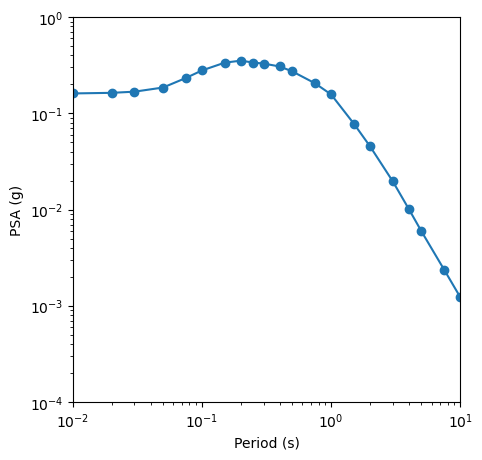

In [18]:
r = 35
mag = 6.5
response=plt.figure(figsize = (5,5))
plt.loglog(T,np.exp(df_plot_predict_ensemble.iloc[df_plot[(df_plot.Earthquake_Magnitude == mag) & (df_plot.ClstD_km == r)].index[0],1:22]),'o-')

plt.xlabel('Period (s)')
plt.ylabel('PSA (g)')
plt.ylim([0.0001, 1])
plt.xlim([0.01, 10])